In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow.keras import models,layers
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:

import os

# Define the path to the directory
directory_path = "/content/drive/MyDrive/plantvillage"

# Check if the directory exists
if os.path.exists(directory_path):
    # Now you can access files inside this directory
    # For example, you can list the files in the directory
    files = os.listdir(directory_path)
    print("Files in plantvillage directory:")
    for file in files:
        print(file)
else:
    print("Directory not found.")


Files in plantvillage directory:
Potato___healthy
Potato___Early_blight
Potato___Late_blight


In [ ]:
import keras

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS= 50
CHANNELS = 3

In [ ]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(directory_path,shuffle=True,image_size=(IMAGE_SIZE,IMAGE_SIZE),batch_size=BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [ ]:
class_names=dataset.class_names
print(class_names)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [ ]:
len(dataset)

68

In [ ]:
68*32

2176

In [ ]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 1 2 0 1 2 0 1 0 1 1 0 0 1 1 1 0 0 0 0 1 0 1 1 0 1 1 0 0 0 0]


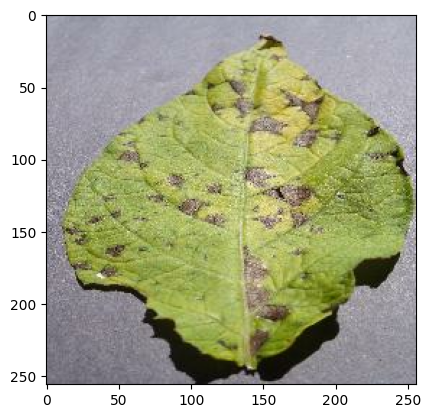

In [ ]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[1].numpy().astype("uint8"))

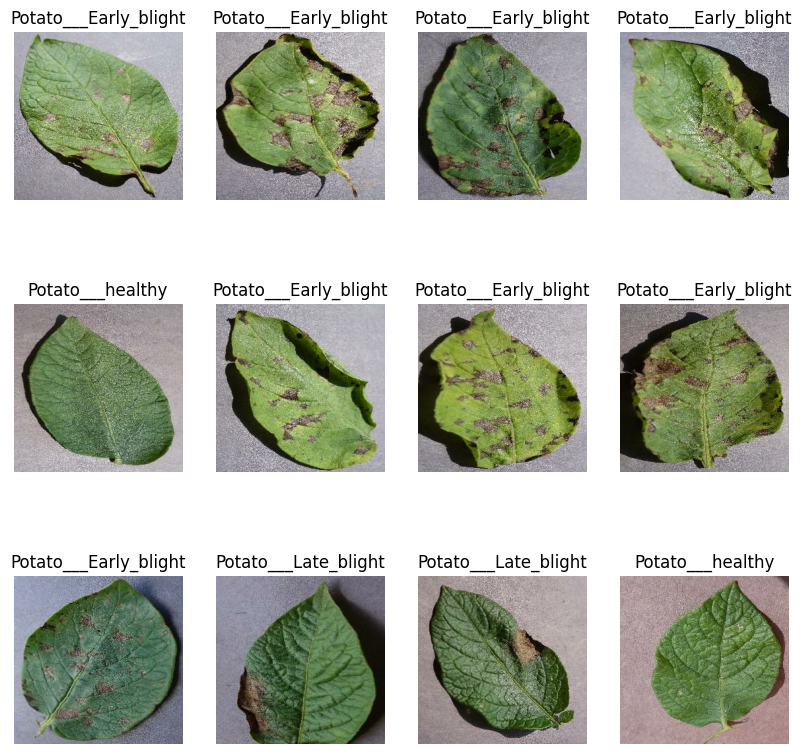

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")


In [ ]:
#80% ==> training data
#20% ==> testing data 10% validation

In [ ]:
train_size = 0.8

len(dataset)*train_size

54.400000000000006

In [ ]:
train_ds=dataset.take(54)
len(train_ds)
                                                                                      # 54 batches,1 batch contain 32

54

In [ ]:
test_ds=dataset.skip(54)
len(test_ds)
                                                                                           # we are skip the first 54 datasets

14

In [ ]:
val_size = 0.1
len(dataset)*val_size                                                                                           #validation dataset given 10%

6.800000000000001

In [ ]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [ ]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [ ]:
def get_datasets_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle_size=1000,shuffle=True):
    ds_size=len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds=ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)


    return train_ds,val_ds,test_ds

In [ ]:
 train_ds,val_ds,test_ds = get_datasets_partitions_tf(dataset)

In [ ]:
len(train_ds)

54

In [ ]:
len(val_ds)

6

In [ ]:
len(test_ds)

8

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds =  val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)


In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
dataagumentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)

])

In [ ]:
from tensorflow.keras.layers import Conv2D
from keras import models


In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    dataagumentation,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])


model.build(input_shape=input_shape)


In [ ]:



model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [ ]:
model.compile(
    optimizer='rmsprop',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = "accuracy",)

In [ ]:
history = model.fit(train_ds, batch_size=BATCH_SIZE, validation_data= val_ds, verbose= 1,epochs = EPOCHS)

In [ ]:
len(test_ds)

8

In [ ]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 8s 30ms/step - loss: 0.0224 - accuracy: 0.9922


In [ ]:
scores

[0.022415729239583015, 0.9921875]

In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

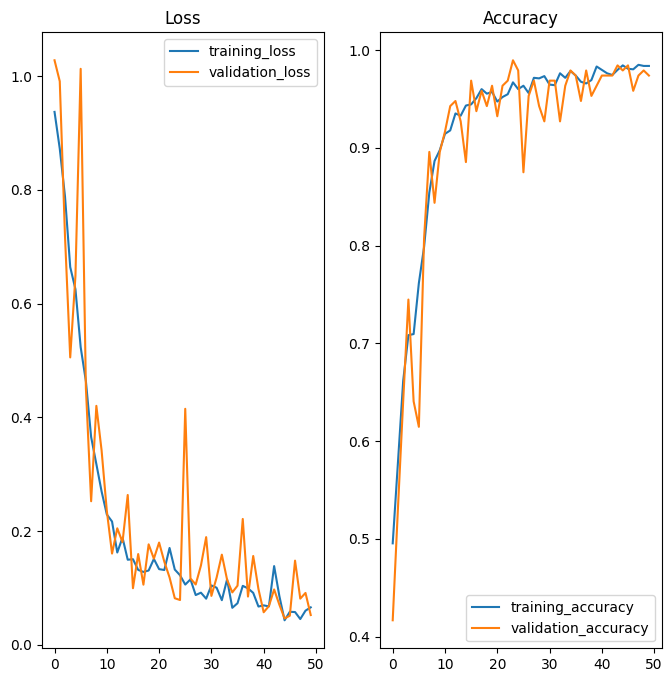

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))  # Specify the figsize as a tuple (width, height)
plt.subplot(1, 2, 1)  # Use subplot to create multiple plots in a single figure
plt.plot(range(EPOCHS), loss, label='training_loss')  # Corrected the range() function
plt.plot(range(EPOCHS), val_loss, label='validation_loss')  # Corrected the range() function
plt.legend(loc='upper right')  # Specify the location of the legend
plt.title('Loss')  # Set the title for this subplot

plt.subplot(1, 2, 2)  # Second subplot
plt.plot(range(EPOCHS), acc, label='training_accuracy')  # Corrected the range() function
plt.plot(range(EPOCHS), val_acc, label='validation_accuracy')  # Corrected the range() function
plt.legend(loc='lower right')  # Specify the location of the legend
plt.title('Accuracy')  # Set the title for this subplot

plt.show()


In [ ]:
def predict(model, image):
    # Assuming model.predict returns a tuple of (predicted_class, confidence)
    prediction = model.predict(image)
    predicted_class = prediction.argmax()
    confidence = prediction.max() * 100  # Assuming confidence is represented as a percentage
    return predicted_class, confidence


1/1 [==============================] - 0s 22ms/step


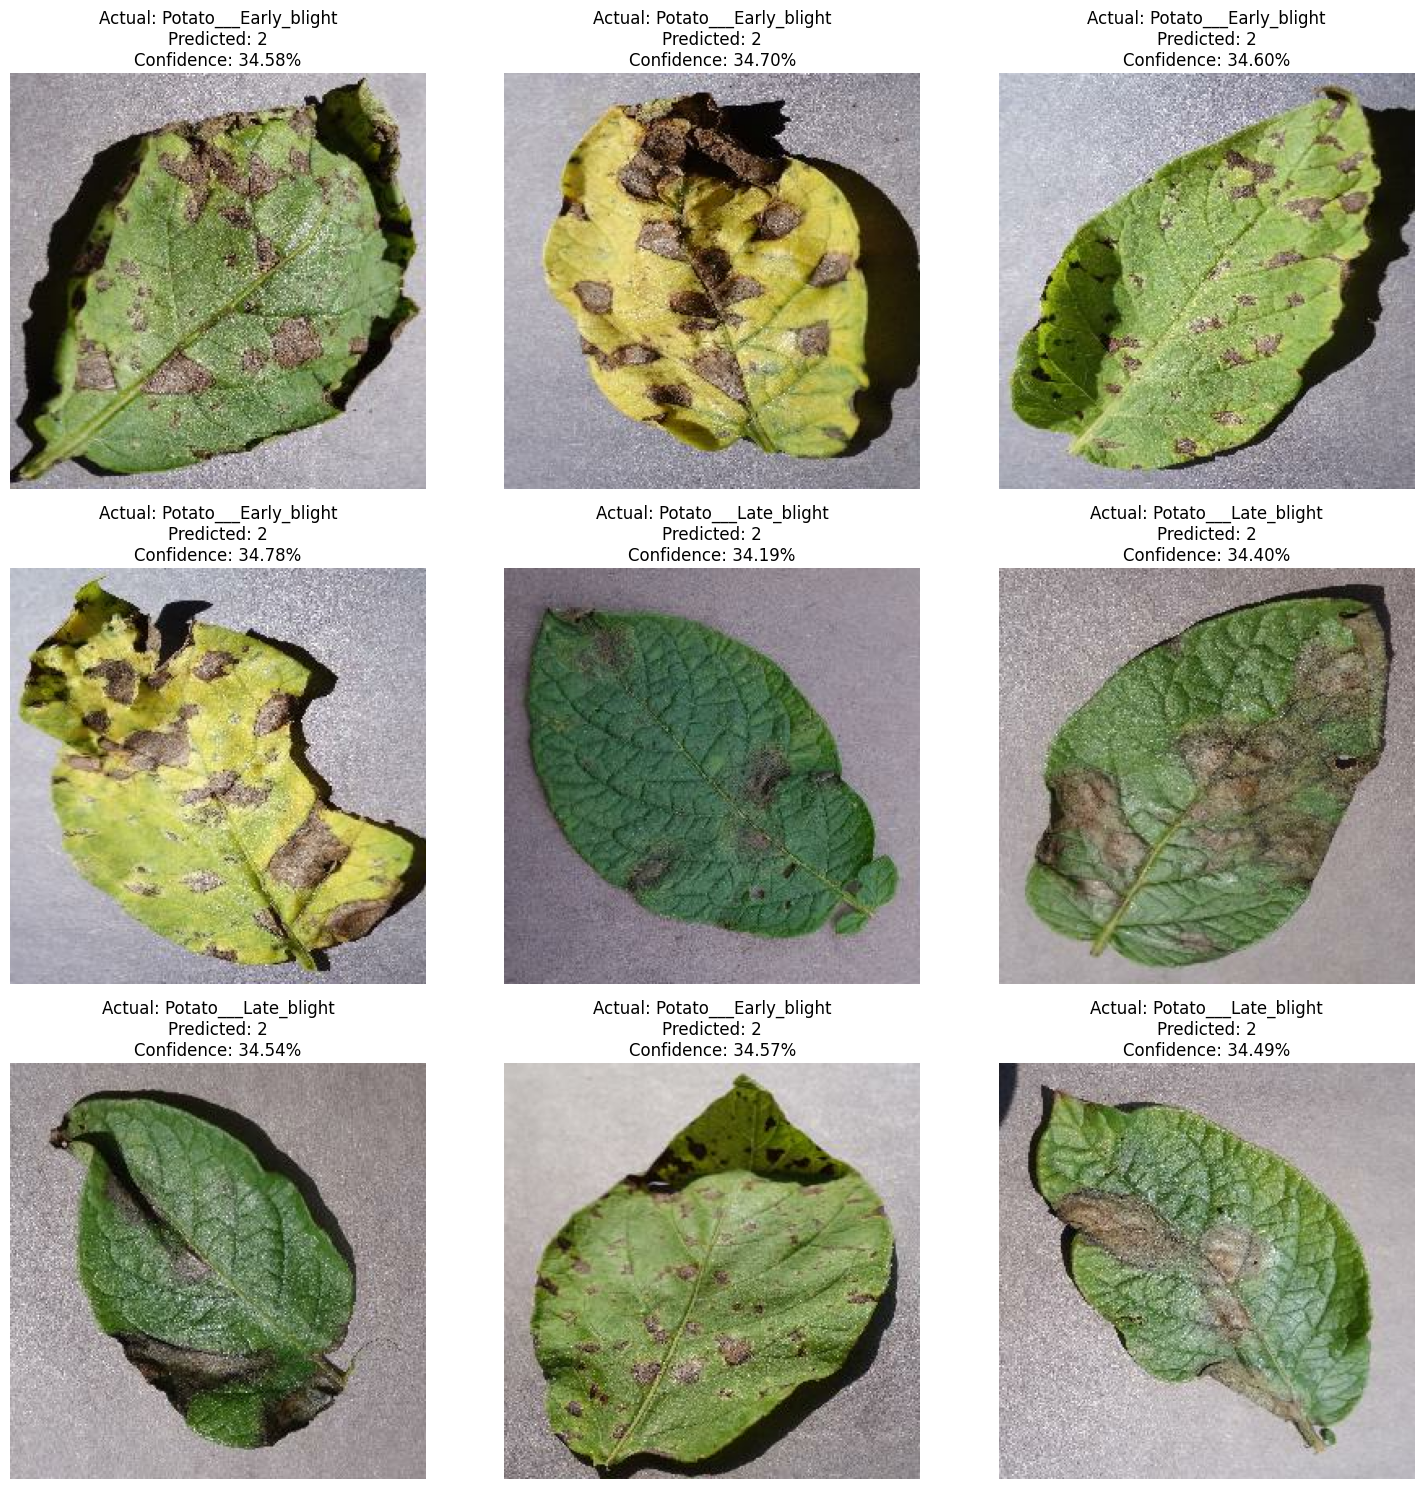

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        # Reshape the input image to match the expected shape
        input_image = tf.expand_dims(images[i], axis=0)  # Add batch dimension

        # Predict the class and confidence for the input image
        prediction_class, confidence = predict(model, input_image)

        actual_class = class_names[labels[i]]

        # Set title with larger font size
        plt.title(f"Actual: {actual_class}\nPredicted: {prediction_class}\nConfidence: {confidence:.2f}%", fontsize=12)

        plt.axis("off")

plt.tight_layout()  # Adjust layout to prevent overlapping titles
plt.show()  # Show each set of 9 images together



In [ ]:
# Given link
drive_link = "https://drive.google.com/drive/folders/1bituvNmdTXMB349tlMy6fEqCvIkGNWGr?usp=drive_link"

# Extract folder ID from the link
folder_id_index = drive_link.find("/folders/") + len("/folders/")
folder_id = drive_link[folder_id_index:].split("?")[0]

# Construct path
drive_path = f"https://drive.google.com/drive/folders/{folder_id}"

print("Drive path:", drive_path)


Drive path: https://drive.google.com/drive/folders/1bituvNmdTXMB349tlMy6fEqCvIkGNWGr


1/1 [==============================] - 0s 24ms/step


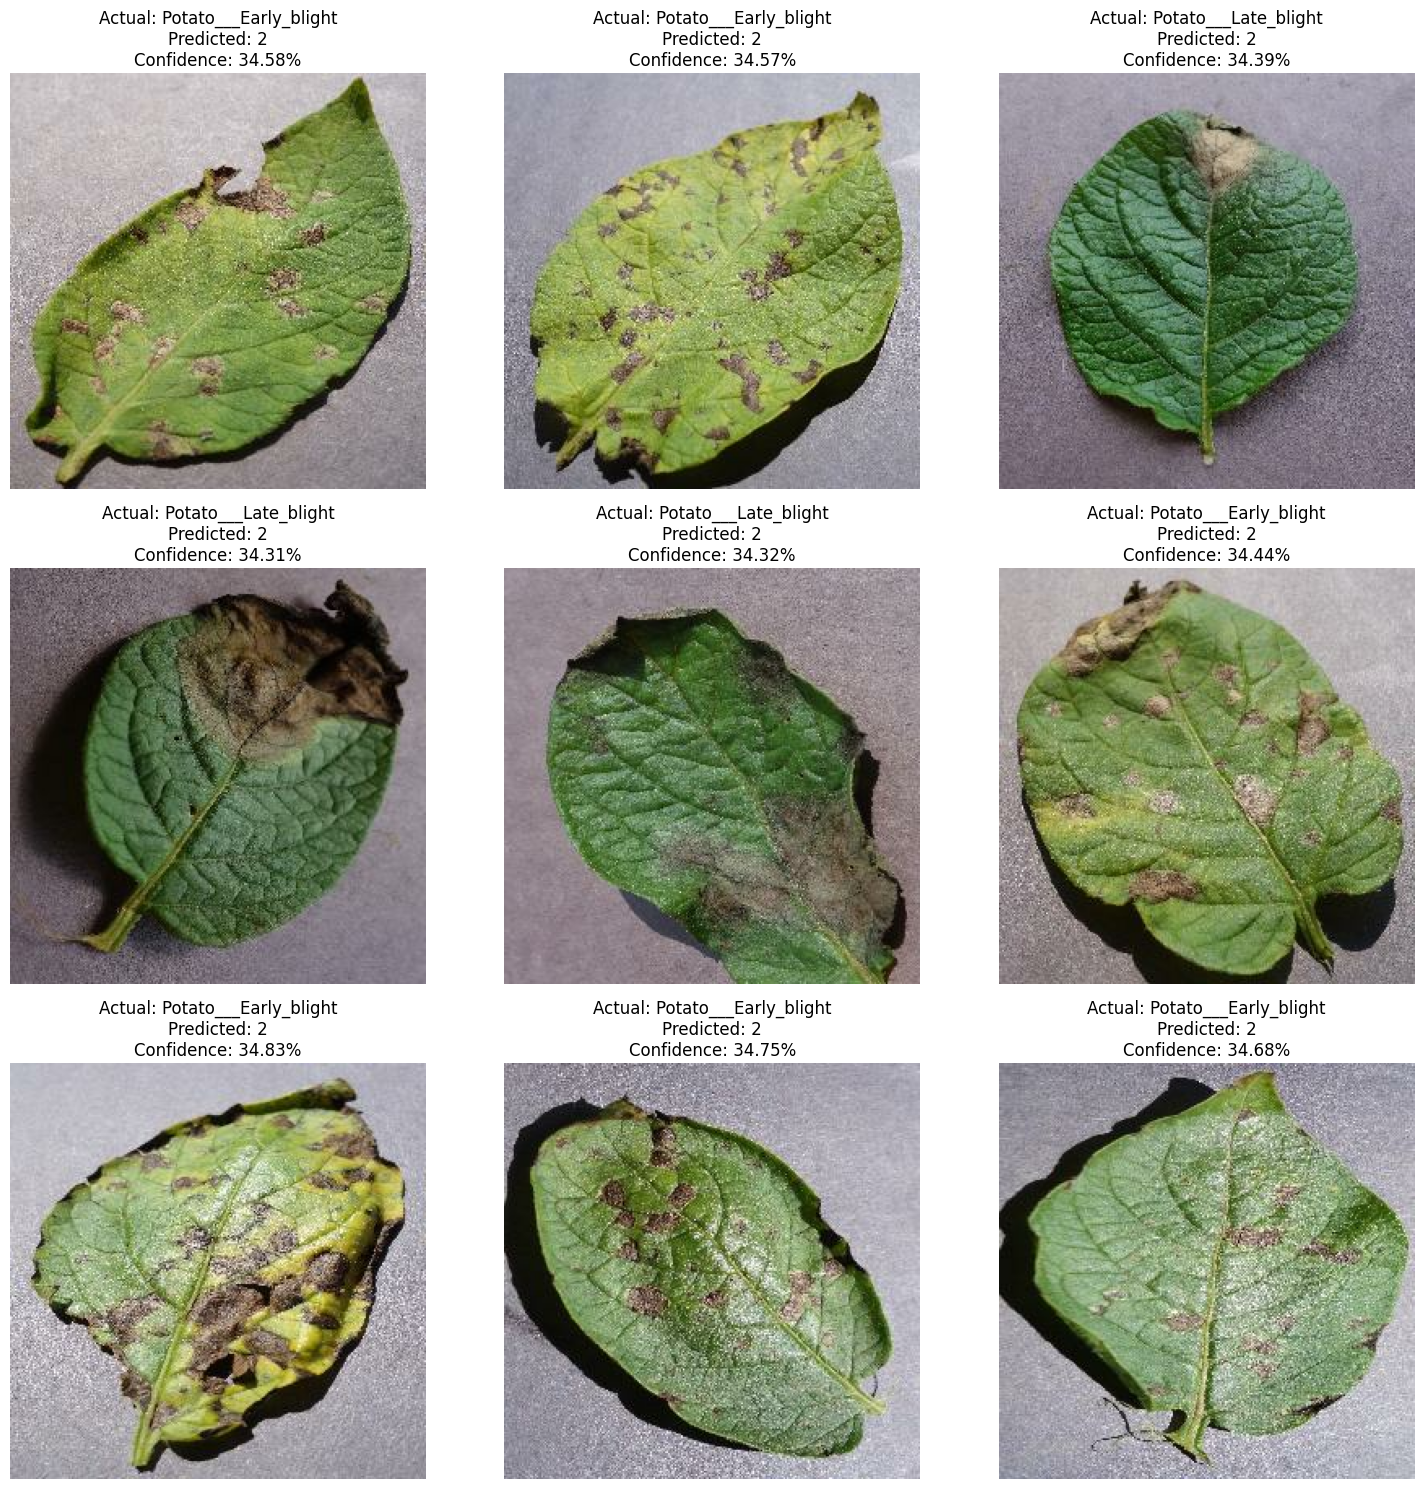

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        # Reshape the input image to match the expected shape
        input_image = tf.expand_dims(images[i], axis=0)  # Add batch dimension

        # Predict the class and confidence for the input image
        prediction_class, confidence = predict(model, input_image)

        actual_class = class_names[labels[i]]

        # Set title with larger font size
        plt.title(f"Actual: {actual_class}\nPredicted: {prediction_class}\nConfidence: {confidence:.2f}%", fontsize=12)

        plt.axis("off")

plt.tight_layout()  # Adjust layout to prevent overlapping titles
plt.show()  # Show each set of 9 images together


In [ ]:
# Set the path to save the model in Google Drive
model_save_path = '/content/drive/My Drive/module/model_version_1'

# Save the model
model.save(model_save_path)